> A simple use case demo for using geowrangler modules to find the Philippine provinces/towns with the slowest/fastest internet speeds.

[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/overview.usecase_ookla.ipynb)

In [ ]:
#| include: false
# all_slow
# all_no_test

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq fastparquet
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Summary

This **Use Case Demo** shows how to use the [_geowrangler.datasets.ookla_](./datasets_ookla.html) and the [*geowrangler.area_zonal_stats*](./area_zonal_stats.html) modules to find the slowest/fastest internet speeds within an area or region of interest.


### How geowrangler can make this process easier

Geowrangler can:

* Validate your geodataframes
* Help you download Ookla data (internet speed)
* Generate zonal stats for your province/town

### What you need to do

* Get your AOIs (areas of interest) - get the boundaries of your administrative regions
* Download ookla data
* Validate AOIs and ookla data
* Generate zonal Stats
* Analyze and find fastest/slowest internet speeds

## Tutorial 


### Import libraries

Lets start by importing the required libraries

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import geowrangler.area_zonal_stats as azs

In [ ]:
#| include: false
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data

### Download Admin Areas

Next, we get the administrative boundaries geodataset using [data from Humanitarian Data Exchange](https://data.humdata.org/dataset/cod-ab-phl)  

#### Set Region Filter
:::{.callout-important}

Setting the region filter to `None` will compute the zonal stats for the whole Philippines and can take a lot longer than for a region.

:::

Set the **REGION_FILTER** to your Region (or `None` for the whole Philippines).

In [ ]:
# REGION_FILTER = None  # All regions
REGION_FILTER = "National Capital Region (NCR)"  # limit to 1 to speed up processin

Download the geodataset containing the admin areas of your country.

Here we are using the data for the Philippines.

In [ ]:
#| no_test
phl_admin_file = "phl_adminboundaries"
phl_admin_zip = f"{phl_admin_file}.zip"
# shapefiles
phl_admin_link = f"https://data.humdata.org/dataset/caf116df-f984-4deb-85ca-41b349d3f313/resource/12457689-6a86-4474-8032-5ca9464d38a8/download/phl_adm_psa_namria_20231106_shp.zip"

Download the zipped file. Depending on your internet connection, it can take several minutes.

In [ ]:
%%time
#| no_test
![ ! -e ../data/{phl_admin_zip} ] && curl -L -o ../data/{phl_admin_zip} {phl_admin_link}

CPU times: user 901 µs, sys: 2.68 ms, total: 3.59 ms
Wall time: 279 ms


In [ ]:
!mkdir -p ../data/{phl_admin_file}

In [ ]:
main_file = "phl_admbnda_adm3_psa_namria_20231106"
phl_admin3_shp = f"../data/{phl_admin_file}/{main_file}.shp"

In [ ]:
%%time
![ ! -e {phl_admin3_shp} ] && unzip -d ../data/{phl_admin_file} ../data/{phl_admin_zip}

CPU times: user 907 µs, sys: 2.5 ms, total: 3.41 ms
Wall time: 279 ms


Load the admin area geo dataset. 

In our example we are loading the `.shp` or shape file as a geopandas dataframe.

In [ ]:
%%time
print(f"loading {phl_admin3_shp}")
admin3 = gpd.read_file(phl_admin3_shp)

loading ../data/phl_adminboundaries/phl_admbnda_adm3_psa_namria_20231106.shp
CPU times: user 245 ms, sys: 68.7 ms, total: 313 ms
Wall time: 327 ms


In [ ]:
admin3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry
0,Adams,PH0102801,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.423604,0.009506,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463..."
1,Bacarra,PH0102802,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.309136,0.004725,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282..."
2,Badoc,PH0102803,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.599295,0.006880,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977..."
3,Bangui,PH0102804,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.483066,0.009843,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533..."
4,City of Batac,PH0102805,Ilocos Norte,PH01028,Region I (Ilocos Region),PH01,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.613500,0.013493,158.123132,"POLYGON ((120.61242 18.10947, 120.612 18.10679..."


In [ ]:
list(admin3.columns.values)

['ADM3_EN',
 'ADM3_PCODE',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'ADM3_REF',
 'ADM3ALT1EN',
 'Shape_Leng',
 'Shape_Area',
 'AREA_SQKM',
 'geometry']

In [ ]:
admin3.ADM1_EN.unique()

array(['Region I (Ilocos Region)', 'Region II (Cagayan Valley)',
       'Region III (Central Luzon)', 'Region IV-A (Calabarzon)',
       'Region V (Bicol Region)', 'Region VI (Western Visayas)',
       'Region VII (Central Visayas)', 'Region VIII (Eastern Visayas)',
       'Region IX (Zamboanga Peninsula)', 'Region X (Northern Mindanao)',
       'Region XI (Davao Region)', 'Region XII (Soccsksargen)',
       'National Capital Region (NCR)',
       'Cordillera Administrative Region (CAR)', 'Region XIII (Caraga)',
       'Mimaropa Region',
       'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)'],
      dtype=object)

Limit the admin regions to only 1 in order to make the process run faster. 

The **REGION FILTER** is set in the [Set Region Filter Section](#Set-Region-Filter)

In [ ]:
if REGION_FILTER:
    admin3 = admin3[admin3.ADM1_EN == REGION_FILTER]

In [ ]:
import matplotlib.pyplot as plt

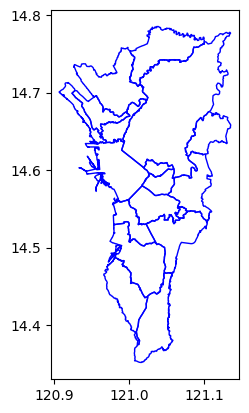

In [ ]:
ax = plt.axes()
ax = admin3.plot(ax=ax, facecolor="none", edgecolor="blue")

![Admin 3 Levels for NCR](images/admin3-ncr.png)

In [ ]:
#| include: false
# uncomment the statement below to show an interactive map
# admin3.explore(tooltip='ADM3_EN')

CPU times: user 22.8 ms, sys: 1.43 ms, total: 24.2 ms
Wall time: 23.7 ms


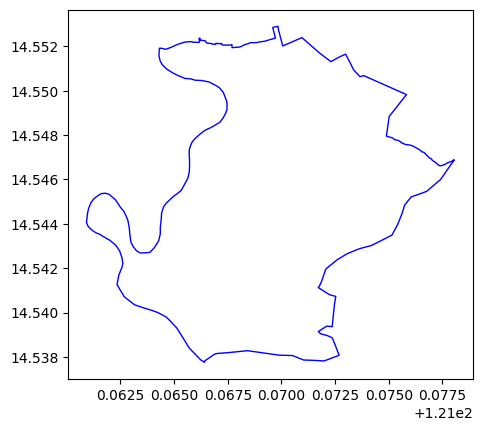

In [ ]:
%%time
ax = plt.axes()
ax = admin3[admin3.ADM3_EN == "Pateros"].plot(ax=ax, facecolor="none", edgecolor="blue")

In [ ]:
admin3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
admin3.total_bounds

array([120.90639543,  14.35172957, 121.13503641,  14.78529173])

In [ ]:
len(admin3)

17

### Download Ookla data

Use the `geowrangler.datasets.ookla` module to explore and download ookla (internet speed) data

In [ ]:
from geowrangler.datasets import ookla

List the publically available ookla datasets

In [ ]:
%%time
ookla_dsets = ookla.list_ookla_files()
ookla_dsets

CPU times: user 34.2 ms, sys: 2.73 ms, total: 36.9 ms
Wall time: 639 ms


{OoklaQuarter(type='fixed', year='2019', quarter='1'): '2019-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='2'): '2019-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='3'): '2019-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2019', quarter='4'): '2019-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='1'): '2020-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='2'): '2020-04-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='3'): '2020-07-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2020', quarter='4'): '2020-10-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='1'): '2021-01-01_performance_fixed_tiles.parquet',
 OoklaQuarter(type='fixed', year='2021', quarter='2'): '2021-04-01_performance_fixed_tiles.

Download the latest data (as of the time of writing this)

In [ ]:
ookla_params = dict(year="2022", quarter="2", directory="../data")

In [ ]:
%%time
ookla_fixed = ookla.download_ookla_file(type_="fixed", **ookla_params)

CPU times: user 126 µs, sys: 63 µs, total: 189 µs
Wall time: 139 µs


In [ ]:
ookla_fixed

Path('../data/2022-04-01_performance_fixed_tiles.parquet')

### Convert ookla data into a GeoDataFrame

The downloaded file from ookla is not yet a geodataset, so we will h
have to convert it into a `GeoDataFrame` suitable for use in geowrangler.

In [ ]:
import pandas as pd

The downloaded ookla data contains the internet speed data for the whole world and can take a minute or two to load.

Later, we will show how to filter the data to only include the data relevant to our AOI.

In [ ]:
%%time
fixed = pd.read_parquet(ookla_fixed)

CPU times: user 3.1 s, sys: 1.57 s, total: 4.67 s
Wall time: 4.27 s


In [ ]:
len(fixed)

6598700

In [ ]:
fixed.head()

,quadkey,tile,tile_x,tile_y,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices
0,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",-160.0241,70.6427,8324,3798,91,NaN,NaN,2,1
1,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",-160.0241,70.6409,14972,4461,94,NaN,NaN,29,2
2,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",-160.0406,70.6336,6253,2818,91,NaN,NaN,1,1
3,0022202203233313,"POLYGON((-179.478149414062 68.9169336615194, -...",-179.4754,68.9159,700,126,1090,NaN,NaN,1,1
4,0022222211003013,"POLYGON((-178.884887695312 67.048162117316, -1...",-178.8821,67.0471,6617,2019,977,NaN,NaN,1,1


In [ ]:
fixed.dtypes

quadkey             object
tile                object
tile_x             float64
tile_y             float64
avg_d_kbps           int64
avg_u_kbps           int64
avg_lat_ms           int64
avg_lat_down_ms    float64
avg_lat_up_ms      float64
tests                int64
devices              int64
dtype: object

The data is now a Pandas `DataFrame` but this needs to be converted to a `GeoDataFrame` by converting the `tile` column into a `geometry` with a `crs` (Coordinate Reference System).

See [EPSG:4326](https://epsg.io/4326) for more details about the CRS.

Converting the data can also take a minute or two.

In [ ]:
%%time
fixed["geometry"] = gpd.GeoSeries.from_wkt(fixed.tile, crs="EPSG:4326")

CPU times: user 7.99 s, sys: 775 ms, total: 8.77 s
Wall time: 9.25 s


In [ ]:
fixed.head()

,quadkey,tile,tile_x,tile_y,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,geometry
0,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",-160.0241,70.6427,8324,3798,91,NaN,NaN,2,1,"POLYGON ((-160.02686 70.64359, -160.02136 70.6..."
1,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",-160.0241,70.6409,14972,4461,94,NaN,NaN,29,2,"POLYGON ((-160.02686 70.64177, -160.02136 70.6..."
2,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",-160.0406,70.6336,6253,2818,91,NaN,NaN,1,1,"POLYGON ((-160.04333 70.63448, -160.03784 70.6..."
3,0022202203233313,"POLYGON((-179.478149414062 68.9169336615194, -...",-179.4754,68.9159,700,126,1090,NaN,NaN,1,1,"POLYGON ((-179.47815 68.91693, -179.47266 68.9..."
4,0022222211003013,"POLYGON((-178.884887695312 67.048162117316, -1...",-178.8821,67.0471,6617,2019,977,NaN,NaN,1,1,"POLYGON ((-178.88489 67.04816, -178.87939 67.0..."


In [ ]:
%%time
fixed = fixed.drop(columns=["tile"])

CPU times: user 106 ms, sys: 276 ms, total: 382 ms
Wall time: 592 ms


In [ ]:
%%time
fixed = gpd.GeoDataFrame(fixed, geometry="geometry", crs="EPSG:4326")

CPU times: user 161 ms, sys: 105 ms, total: 266 ms
Wall time: 343 ms


### Validate AOI and Data Geometries

In order to prevent more headaches as we process and analyze geospatial datasets down the line, it is prudent to check 
that our datasets have valid geometries.

We can use the `geowrangler.validation` module to check as well fix these problems.

In [ ]:
from geowrangler.validation import GeometryValidation

#### Validate AOI

In [ ]:
admin3_gvm = GeometryValidation(admin3)

In [ ]:
%%time
valid_admin3 = admin3_gvm.validate_all()

CPU times: user 33 ms, sys: 2.37 ms, total: 35.4 ms
Wall time: 35 ms


In [ ]:
valid_admin3.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,is_not_null,is_not_self_intersecting,is_oriented_properly,is_within_crs_bounds,area_is_not_zero
1275,City of Manila,PH1303901,Metropolitan Manila First District,PH13039,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.600152,0.003520,41.960090,"POLYGON ((120.98508 14.63998, 120.98502 14.639...",True,True,False,True,True
1276,City of Mandaluyong,PH1307401,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.141520,0.000949,11.314034,"POLYGON ((121.05966 14.59007, 121.05729 14.589...",True,True,False,True,True
1277,City of Marikina,PH1307402,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.257017,0.001924,22.931403,"POLYGON ((121.13338 14.65369, 121.13344 14.653...",True,True,False,True,True
1278,City of Pasig,PH1307403,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.344848,0.002626,31.304225,"POLYGON ((121.10188 14.62066, 121.09785 14.619...",True,True,False,True,True
1279,Quezon City,PH1307404,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.773902,0.013630,162.439224,"POLYGON ((121.12563 14.71782, 121.1256 14.7178...",True,True,False,True,True


In [ ]:
valid_cols = [
    "is_oriented_properly",
    "is_not_null",
    "is_not_self_intersecting",
    "is_within_crs_bounds",
    "area_is_not_zero",
]

In [ ]:
[valid_admin3[col].value_counts() for col in valid_cols]

[is_oriented_properly
 False    17
 Name: count, dtype: int64,
 is_not_null
 True    17
 Name: count, dtype: int64,
 is_not_self_intersecting
 True    17
 Name: count, dtype: int64,
 is_within_crs_bounds
 True    17
 Name: count, dtype: int64,
 area_is_not_zero
 True    17
 Name: count, dtype: int64]

So the admin areas have their geometry _improperly oriented_ (i.e. layed out in a counter clockwise direction instead of clockwise direction) and
this has been fixed, but passes all the other default validations.

In [ ]:
valid_admin3 = valid_admin3.drop(columns=valid_cols)

#### Validate Data Geometries

Before validating, let's filter the data to only those intersecting our AOI because we don't need to check all the data from around the world
when we're only interested in our AOI.

Before we validate, we need to create the spatial indexes for both the AOI and data geometries. Generating the spatial 
indexes of the data geometries can take a minute or two due to the size of the data and their geometries.

In [ ]:
%%time
valid_admin3.geometry.sindex

CPU times: user 181 µs, sys: 7 µs, total: 188 µs
Wall time: 190 µs


<geopandas.sindex.SpatialIndex>

In [ ]:
%%time
fixed.geometry.sindex

CPU times: user 1.31 s, sys: 1.4 s, total: 2.71 s
Wall time: 3.52 s


<geopandas.sindex.SpatialIndex>

Lets now filter the data (`filtered_fixed`). 

Filtering the data using a spatial join can also take a minute or two.

In [ ]:
%%time
filtered_fixed = fixed.sjoin(
    valid_admin3[["geometry"]], how="inner", predicate="intersects"
)

CPU times: user 244 ms, sys: 587 ms, total: 830 ms
Wall time: 1.42 s


In [ ]:
filtered_fixed = filtered_fixed.drop(columns=["index_right"])

In [ ]:
fixed_gvm = GeometryValidation(filtered_fixed)

In [ ]:
%%time
valid_fixed = fixed_gvm.validate_all()

CPU times: user 182 ms, sys: 5.59 ms, total: 188 ms
Wall time: 202 ms


In [ ]:
%%time
[valid_fixed[col].value_counts() for col in valid_cols]

CPU times: user 595 µs, sys: 97 µs, total: 692 µs
Wall time: 695 µs


[is_oriented_properly
 False    2202
 Name: count, dtype: int64,
 is_not_null
 True    2202
 Name: count, dtype: int64,
 is_not_self_intersecting
 True    2202
 Name: count, dtype: int64,
 is_within_crs_bounds
 True    2202
 Name: count, dtype: int64,
 area_is_not_zero
 True    2202
 Name: count, dtype: int64]

Again the data geometries have an improperly oriented geometry and have been fixed by the validator

In [ ]:
valid_fixed = valid_fixed.drop(columns=valid_cols)
filtered_fixed = valid_fixed

![filtered fixed ookla data](images/fixed-ookla-admin3-ncr-2020q2.png)

In [ ]:
# | include: false
# uncomment the statement below to show an interactive map
# filtered_fixed.explore(column='avg_d_kbps', cmap='viridis', tooltip='avg_d_kbps')


### Generate Zonal Stats


Lets now generate the zonal stats -- the statistics of the data we are interested in.

In [ ]:
filtered_fixed.head()

,quadkey,tile_x,tile_y,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,geometry
5658690,1323030313311323,120.9238,14.7350,43033,47711,9,NaN,NaN,92,23,"POLYGON ((120.92102 14.7377, 120.92102 14.7323..."
5658692,1323030313311332,120.9293,14.7350,72579,91717,11,NaN,NaN,149,36,"POLYGON ((120.92651 14.7377, 120.92651 14.7323..."
5658693,1323030313311333,120.9348,14.7350,52572,67337,3,NaN,NaN,1,1,"POLYGON ((120.93201 14.7377, 120.93201 14.7323..."
5658698,1323030313313033,120.9128,14.7138,7615,11991,14,NaN,NaN,14,3,"POLYGON ((120.91003 14.71645, 120.91003 14.711..."
5658702,1323030313313110,120.9293,14.7297,63551,77540,14,NaN,NaN,600,69,"POLYGON ((120.92651 14.73239, 120.92651 14.727..."


In [ ]:
list(filtered_fixed.columns.values)

['quadkey',
 'tile_x',
 'tile_y',
 'avg_d_kbps',
 'avg_u_kbps',
 'avg_lat_ms',
 'avg_lat_down_ms',
 'avg_lat_up_ms',
 'tests',
 'devices',
 'geometry']

In [ ]:
len(filtered_fixed)

2202

Convert to planar CRS (since we are computing areas)

In [ ]:
%%time
valid_admin3 = valid_admin3.to_crs("EPSG:3857")

CPU times: user 5.53 ms, sys: 2.28 ms, total: 7.81 ms
Wall time: 13 ms


In [ ]:
%%time
filtered_fixed = filtered_fixed.to_crs("EPSG:3857")

CPU times: user 3.5 ms, sys: 1.08 ms, total: 4.58 ms
Wall time: 4.43 ms


Lets save the files so we can retrieve them as necessary without having to reprocess them again.

In [ ]:
%%time
valid_admin3.to_file("../data/valid_admin3.geojson", driver="GeoJSON")

CPU times: user 81.4 ms, sys: 3.95 ms, total: 85.3 ms
Wall time: 87.2 ms


In [ ]:
%%time
filtered_fixed.to_file("../data/filtered_fixed.geojson", driver="GeoJSON")

CPU times: user 45.2 ms, sys: 2.77 ms, total: 47.9 ms
Wall time: 48.9 ms


In [ ]:
# %%time
# valid_admin3 = gpd.read_file("../data/valid_admin3.geojson")

In [ ]:
# %%time
# filtered_fixed = gpd.read_file("../data/filtered_fixed.geojson")

We want the following statistics - `mean` (aka average), `min` (minimum), `max` (maximum) and the standard deviation (`std`)
for the 3 data columns that ookla provides - average download speed (`avg_d_kbps`), average upload speed (`avg_u_kbps`) and average latency in milliseconds (`avg_lat_ms`)

In [ ]:
funcs = ["mean", "min", "max", "std"]
columns = ["avg_d_kbps", "avg_u_kbps", "avg_lat_ms"]

In [ ]:
aggregations = [dict(func=funcs, column=c) for c in columns]

These are the aggregations to be performed for each data column

In [ ]:
aggregations

[{'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_d_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_u_kbps'},
 {'func': ['mean', 'min', 'max', 'std'], 'column': 'avg_lat_ms'}]

The output columns use the default `{column}_{func}` format if not explicitly specified.

In [ ]:
%%time
aoi = azs.create_area_zonal_stats(
    valid_admin3, filtered_fixed, aggregations=aggregations
)

CPU times: user 287 ms, sys: 12.5 ms, total: 300 ms
Wall time: 304 ms



### Analyze Zonal Stats


These are the results - the same dataframe as the original, with the addition of zonal statistics we specified as the aggregations.

In [ ]:
aoi.head()

,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,ADM3_REF,ADM3ALT1EN,Shape_Leng,Shape_Area,AREA_SQKM,geometry,intersect_area_sum,avg_d_kbps_mean,avg_d_kbps_min,avg_d_kbps_max,avg_d_kbps_std,avg_u_kbps_mean,avg_u_kbps_min,avg_u_kbps_max,avg_u_kbps_std,avg_lat_ms_mean,avg_lat_ms_min,avg_lat_ms_max,avg_lat_ms_std
1275,City of Manila,PH1303901,Metropolitan Manila First District,PH13039,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.600152,0.003520,41.960090,"POLYGON ((13467997.788 1647743.669, 13467990.2...",5.319784e+07,480.501342,0.0,208079,19451.400409,401.935738,0.0,252268,21777.859621,0.042510,0.0,160,11.038219
1276,City of Mandaluyong,PH1307401,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.141520,0.000949,11.314034,"POLYGON ((13476299.72 1642002.083, 13476035.58...",1.861584e+07,1556.122992,0.0,169221,19460.297726,1391.349828,0.0,192392,22225.667081,0.141840,0.0,15,2.309665
1277,City of Marikina,PH1307402,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.257017,0.001924,22.931403,"POLYGON ((13484505.693 1649321.548, 13484512.7...",2.925728e+07,890.018039,0.0,144549,15060.305627,814.873754,0.0,132992,15016.269054,0.060550,0.0,22,2.928328
1278,City of Pasig,PH1307403,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.344848,0.002626,31.304225,"POLYGON ((13480999.467 1645520.671, 13480550.6...",4.235474e+07,654.028552,0.0,148007,17091.663647,589.939054,0.0,142586,19958.543519,0.052444,0.0,25,3.773210
1279,Quezon City,PH1307404,Metropolitan Manila Second District,PH13074,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,0000/00/00,None,None,0.773902,0.013630,162.439224,"POLYGON ((13483643.002 1656701.652, 13483639.5...",1.744956e+08,145.327232,0.0,269544,20256.330164,133.237247,0.0,260425,20148.610313,0.011825,0.0,29,2.907006


Lets save the results 

In [ ]:
%%time
aoi.to_file("../data/admin3_internet_aoi.geojson", driver="GeoJSON")

CPU times: user 83.8 ms, sys: 2.89 ms, total: 86.7 ms
Wall time: 101 ms


In [ ]:
list(aoi.columns.values)

['ADM3_EN',
 'ADM3_PCODE',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'validTo',
 'ADM3_REF',
 'ADM3ALT1EN',
 'Shape_Leng',
 'Shape_Area',
 'AREA_SQKM',
 'geometry',
 'intersect_area_sum',
 'avg_d_kbps_mean',
 'avg_d_kbps_min',
 'avg_d_kbps_max',
 'avg_d_kbps_std',
 'avg_u_kbps_mean',
 'avg_u_kbps_min',
 'avg_u_kbps_max',
 'avg_u_kbps_std',
 'avg_lat_ms_mean',
 'avg_lat_ms_min',
 'avg_lat_ms_max',
 'avg_lat_ms_std']

Let's sort the different admin level 3 areas (cities/municipalities/district) by average download speed (`avg_d_kbps_mean`)  in descending order

In [ ]:
%%time
fastest_mean_download = aoi.sort_values("avg_d_kbps_mean", ascending=False)

CPU times: user 423 µs, sys: 61 µs, total: 484 µs
Wall time: 452 µs


In [ ]:
len(fastest_mean_download)

17

So according the latest ookla data (as of this writing) the district/town/province within the NCR Region with the fastest average download speed is **Pateros**!! :)

In [ ]:
fastest_mean_download.iloc[0]

ADM3_EN                                                         Pateros
ADM3_PCODE                                                    PH1307606
ADM2_EN                             Metropolitan Manila Fourth District
ADM2_PCODE                                                      PH13076
ADM1_EN                                   National Capital Region (NCR)
ADM1_PCODE                                                         PH13
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                2022-11-09 00:00:00
validOn                                             2023-11-06 00:00:00
validTo                                                      0000/00/00
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
Shape_Leng                                                     0

While the district/city/municipality within the NCR Regions with the slowest average download speed is **Quezon City**!!! 

In [ ]:
fastest_mean_download.iloc[-1]

ADM3_EN                                                     Quezon City
ADM3_PCODE                                                    PH1307404
ADM2_EN                             Metropolitan Manila Second District
ADM2_PCODE                                                      PH13074
ADM1_EN                                   National Capital Region (NCR)
ADM1_PCODE                                                         PH13
ADM0_EN                                               Philippines (the)
ADM0_PCODE                                                           PH
date                                                2022-11-09 00:00:00
validOn                                             2023-11-06 00:00:00
validTo                                                      0000/00/00
ADM3_REF                                                           None
ADM3ALT1EN                                                         None
Shape_Leng                                                     0

The top 5 fastest areas are

In [ ]:
fastest_mean_download[["ADM3_EN", "ADM2_EN", "avg_d_kbps_mean"]].head()

,ADM3_EN,ADM2_EN,avg_d_kbps_mean
1290,Pateros,Metropolitan Manila Fourth District,7583.799743
1280,City of San Juan,Metropolitan Manila Second District,3060.079907
1276,City of Mandaluyong,Metropolitan Manila Second District,1556.122992
1283,City of Navotas,Metropolitan Manila Third District,1065.788943
1282,City of Malabon,Metropolitan Manila Third District,1006.571673


The top 5 slowest areas are

In [ ]:
fastest_mean_download[["ADM3_EN", "ADM2_EN", "avg_d_kbps_mean"]].tail()

,ADM3_EN,ADM2_EN,avg_d_kbps_mean
1275,City of Manila,Metropolitan Manila First District,480.501342
1288,City of Parañaque,Metropolitan Manila Fourth District,470.097380
1284,City of Valenzuela,Metropolitan Manila Third District,419.877335
1281,Caloocan City,Metropolitan Manila Third District,311.217504
1279,Quezon City,Metropolitan Manila Second District,145.327232


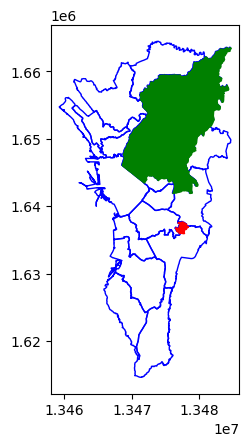

In [ ]:
ax = plt.axes()
ax = fastest_mean_download.plot(ax=ax, facecolor="none", edgecolor="blue")
ax = fastest_mean_download.iloc[:1].plot(ax=ax, facecolor="red", edgecolor="red")
ax = fastest_mean_download.iloc[-1:].plot(ax=ax, facecolor="green", edgecolor="green")

![fastest fixed ookla by adm3](images/fastest-fixed-ookla-by-adm3.png)

In [ ]:
#| include: false
# uncomment the statement below to show an interactive map
# fastest_mean_download.explore(column='avg_d_kbps_mean',cmap='viridis', tooltip='avg_d_kbps_mean')

So now, we've answered the question of where the fastest/slowest internet speeds are for the National Capital Region (NCR)

### Additional Exercises

You can further experiment and try out other exercises to explore ookla data, or even try it out using
a different country using a different geodataset from the Humanitarian Data Exchange site. 

The following are more exercises you can try:

* Repeat the same process to find the fastest and slowest **mobile** internet speeds
* Repeat the same process for a different REGION_FILTER
* Aggregate by adm2 level instead of adm3
